# Depth Data Analysis for DynSLAM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib import rc
# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 6)

# TODO(andrei): Remember that box-and-whisker plots can be VERY informative.

In [2]:
%%bash
(cd ../cmake-build-debug && (ls -t *.csv | head -n 5))

kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-depth-result.csv
kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-3d-tracking-result.csv
kitti-odometry-08-offset-3969-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-depth-result.csv
kitti-odometry-08-offset-3969-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-3d-tracking-result.csv
kitti-odometry-08-offset-3969-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-NO-direct-ref-depth-result.csv


In [3]:
# CSV_FILE_DISPNET = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-08-offset-3969-results.csv"
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

# CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
# CSV_FILE_ELAS="../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

# CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
# CSV_FILE_ELAS="../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

# CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-03-offset-500-depth-precomputed-dispnet-voxelsize-0.0350-max-depth-m-12.00-results.csv"
# CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-03-offset-500-depth-precomputed-elas-voxelsize-0.0350-max-depth-m-12.00-results.csv"

# Same as above but with 16m max depth
# CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-03-offset-500-depth-precomputed-dispnet-voxelsize-0.0350-max-depth-m-16.00-results.csv"
# CSV_FILE_ELAS ="../cmake-build-debug/kitti-odometry-03-offset-500-depth-precomputed-elas-voxelsize-0.0350-max-depth-m-16.00-results.csv"

CSV_FILE_DISPNET = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-results.csv"
CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0500-max-depth-m-20.00-results.csv"

# just trying to see exactly how much better the improvement is
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-tracking-sequence-0004-tracking-dataset-offset-0-depth-precomputed-elas-voxelsize-0.0500-max-depth-m-20.00-results.csv"

UNFAIR COMPARISON!!!


In [82]:
frame_dn = pd.read_csv(CSV_FILE_DISPNET)
frame_elas = pd.read_csv(CSV_FILE_ELAS)
DELTA_MAX = 8

len(frame_dn), len(frame_elas)

def augment(dframe):
    for name in ['input', 'fusion']:
        for delta in range(1, DELTA_MAX+1):
            total = dframe['{}-total-{:.2f}'.format(name, delta)]
            error = dframe['{}-error-{:.2f}'.format(name, delta)]
            missing = dframe['{}-missing-{:.2f}'.format(name, delta)]
            correct = dframe['{}-correct-{:.2f}'.format(name, delta)]

            dframe['{}-error-percent-{:.2f}'.format(name, delta)] = error / total
            dframe['{}-error-and-missing-percent-{:.2f}'.format(name, delta)] = (error+missing) / total
            dframe['{}-missing-percent-{:.2f}'.format(name, delta)] = missing / total
            dframe['{}-correct-percent-{:.2f}'.format(name, delta)] = correct / total

In [9]:
augment(frame_dn)
augment(frame_elas)

## Timeseries Comparison Plots

These could show how the error% for different configs changes over time, in the same plot (cf. the stacked "Timeseries plots" below).

In [ ]:
def timeseries_comp(df, missing_are_errors):
    ax = None
    for i in [1, 3, 8]:
        in_lbl = 'Input error for $\delta_{{max}} = {}$'.format(i)
        in_key = 'input-{}-percent-{}'.format('error-and-missing' if missing_are_errors else 'error', i)
        ax = df[in_key].plot(label=in_lbl)
        
        fus_lbl = 'Fusion error for $\delta_{{max}} = {}$'.format(i)
        fus_key = 'fusion-{}-percent-{}'.format('error-and-missing' if missing_are_errors else 'error', i)
        ax = df[fus_key].plot(label=fus_lbl, marker='x')

    return ax

ax = timeseries_comp(frame_elas, False)
ax.set_ylim([0,1])
ax.set_ylabel("Percentage of error pixels")
ax.set_xlabel("Frame")
ax.legend()

# ax = timeseries_comp(frame_elas, True)

## Boxplots

We could use these plots to compare the error distributions for different scenes and different parameter configurations; for instance, we could show that errors tend to be smaller for dynamic scenes when dynamic objects are accounted for.

In [81]:
def boxplots(elas_frame, dn_frame, delta_max):
    bp_df = pd.DataFrame({
        'ELAS input errors': elas_frame['input-error-percent-{:.2f}'.format(delta_max)],
        'Dispnet input errors': dn_frame['input-error-percent-{:.2f}'.format(delta_max)],
        'ELAS fusion errors': elas_frame['fusion-error-percent-{:.2f}'.format(delta_max)],
        'Dispnet fusion errors': dn_frame['fusion-error-percent-{:.2f}'.format(delta_max)]
    })
    ax = bp_df.boxplot()
    ax.set_ylim([0, 0.5])
    ax.set_ylabel("Percentage of incorrect pixels")
    ax.set_title("For sequence dumped to file {}".format(CSV_FILE_ELAS))
    ax.grid('off')
    
# Well... do note that in the LSD-SLAM paper they don't *really* show the outliers, do they?
boxplots(frame_elas, frame_dn, delta_max=1)

KeyError: 'input-error-percent-1.00'

Inspiration: the boxplots used for the point-to-plane distance based evaluation for LSD-SLAM:

![](img/lsd-slam-results.png)

Note how the libelas errors are actually smaller than their result fused over time. That's quite interesting...

Also note that we can't rely too much on their exact evaluation technique, which aligns MULTIPLE velodyne pointclouds for generating the ground truth, since it wouldn't work in evaluating the accuracy of reconstructing dynamic objects.

FROM THEIR PAPER: We give median, 5th, and 95th percentile on the various Kitti sequences. => No outliers.

## Timeseries Plots 

These can highlight how errors change over time. For dynamic sequences but static reconstruction, these could show error spikes when other moving cars enter view. Then, we could show how (most of) those spikes are mitigated once we become aware of the dynamic objects and start reconstructing them separately.

In [ ]:
def timeplot(frame, delta=5):
    time_colors = ['red', 'green', 'yellow']
    time_names = ['Error','Correct','Missing']
    ax = frame.plot('frame', 
                  ['fusion-error-percent-{}'.format(delta), 
                   'fusion-correct-percent-{}'.format(delta),
                   'fusion-missing-percent-{}'.format(delta)],
                  'area',
                  stacked=True,
                  color=time_colors,
                  title="Fusion stats"
                 )
    ax.legend(time_names)

    ax2 = frame.plot('frame',
                        ['input-error-percent-{}'.format(delta),
                         'input-correct-percent-{}'.format(delta),
                         'input-missing-percent-{}'.format(delta)],
                  'area', stacked=True,
                  color=time_colors,
                  title="Input stats"
                 )
    ax2.legend(time_names)
    
timeplot(frame_elas, 5)
timeplot(frame_dn, 5)

TODO: show arrows pointing to error spikes motivating (e.g. screeshot of car entering frame )

## Aggregate Accuracy Plots

In [125]:
def agggregate_accuracy_comparison(f1, f2, f1_title, f2_title, separate=True):
    accs_input = []
    accs_input_stds = []
    accs_input_e = []
    accs_input_stds_e = []
    accs_fusion = []
    accs_fusion_e = []
    accs_fusion_stds = []
    accs_fusion_stds_e = []
    
    MAX_DELTA_MAX = 5
    delta_maxes = range(1, MAX_DELTA_MAX)

    def stats_for_delta(dframe, name, delta, include_missing):
        total = dframe['{}-total-{:.2f}'.format(name, delta)]
        error = dframe['{}-error-{:.2f}'.format(name, delta)]
        missing = dframe['{}-missing-{:.2f}'.format(name, delta)]
        correct = dframe['{}-correct-{:.2f}'.format(name, delta)]

        if include_missing:
            # Consider missing (uncomputed) values as errors
            accuracy = correct / total
        else:
            accuracy = correct / (total - missing)

        return accuracy.mean(), accuracy.std()

    # We should not count a missing depth value as an error (Peidong)
    missing_are_errors = False
    for i in delta_maxes:
        fus_acc_mean, fus_acc_std = stats_for_delta(f1, 'fusion', i, missing_are_errors)
        fus_acc_mean_e, fus_acc_std_e = stats_for_delta(f2, 'fusion', i, missing_are_errors)
        accs_fusion.append(fus_acc_mean)
        accs_fusion_stds.append(fus_acc_std)
        accs_fusion_e.append(fus_acc_mean_e)
        accs_fusion_stds_e.append(fus_acc_std_e)

        in_acc_mean, in_acc_std = stats_for_delta(f1, 'input', i, missing_are_errors)
        in_acc_mean_e, in_acc_std_e = stats_for_delta(f2, 'input', i, missing_are_errors)
        accs_input.append(in_acc_mean)
        accs_input_stds.append(in_acc_std)
        accs_input_e.append(in_acc_mean_e)
        accs_input_stds_e.append(in_acc_std_e)

    plot_options = {
        'capsize': 4
    }
    
    if separate:
        ax = plt.subplot(121)
        plt.errorbar(delta_maxes, accs_input, accs_input_stds, label='{}: input'.format(f1_title), **plot_options)
        plt.errorbar(delta_maxes, accs_fusion, accs_fusion_stds, label='{}: fused'.format(f1_title), **plot_options)
        plt.xlabel(r"Disparity threshold $\delta_{\textrm{max}}$")
        plt.ylabel(r"Correct pixel ratio")
        plt.ylim([0, 1])
        plt.title("{}".format(f1_title))
        # plt.axvline(x=3)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        plt.legend()
        plt.grid(color='0.7', linestyle='--')

        ax = plt.subplot(122)
        plt.errorbar(delta_maxes, accs_input_e, accs_input_stds_e, label='{}: input'.format(f2_title), **plot_options)
        plt.errorbar(delta_maxes, accs_fusion_e, accs_fusion_stds_e, label='{}: fused'.format(f2_title), **plot_options)
        plt.xlabel(r"Disparity threshold $\delta_{\textrm{max}}$")
        plt.ylabel(r"Correct pixel ratio")
        plt.ylim([0, 1])
        plt.title("{}".format(f2_title))
        # plt.axvline(x=3)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        plt.legend()
        plt.grid(color='0.7', linestyle='--')
    else:
        # !!! Assume the input is the same in both, and plot input plus the two fused 
        # results in a single plot.
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
#         ax.errorbar(delta_maxes, accs_input, accs_input_stds, label='{}: input'.format(f1_title), **plot_options)
#         ax.errorbar(delta_maxes, accs_fusion, accs_fusion_stds, label='{}: fused'.format(f1_title), **plot_options)
#         ax.errorbar(delta_maxes, accs_fusion_e, accs_fusion_stds_e, label='{}: fused'.format(f2_title), **plot_options)
        del plot_options['capsize']
        ax.plot(delta_maxes, accs_input, label='{}: input'.format(f1_title), **plot_options)
        ax.plot(delta_maxes, accs_fusion, label='{}: fused'.format(f1_title), **plot_options)
        ax.plot(delta_maxes, accs_fusion_e, label='{}: fused'.format(f2_title), **plot_options)
        ax.set_xlabel(r"Disparity threshold $\delta_{\textrm{max}}$")
        ax.set_ylabel(r"Correct pixel ratio")
        ax.set_ylim([0.4, 1])
        # TODO proper title
        plt.title("{}".format(f1_title))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        # TODO spawn legend and grid via ax!!
        plt.legend()
        plt.grid(color='0.7', linestyle='--')


#     plt.suptitle("Accuracy: {}".format("Missing=error" if missing_are_errors else "Missing=ignore" ))


In [126]:
%ls img

itm-semantics-depth-plots.png  kitti-depth.png  lsd-slam-results.png


### Issues with the above plots

Right now, we get the unexpected result that the fused data is *less* accurate than the input depth maps. This is so far counterintuitive, since one would expect higher-quality depth maps once several frames are registered. However, this can also lead to an overall loss in precision, since the alignments are never perfect. Our results contradict those from Vineet et al. "Incremental Dense Semantic Stereo Fusion for Large-Scale Semantic Scene Reconstruction", who claim that, at least for static scenes, the fusion should, in fact, really help increase accuracy. Sengupta et al.'s evaluation uses the same principle but is not very clear. They only show that their error decreases the higher they set the error tolerance, i.e., that there's very few LARGE mismatches.

"Reconstructing Street-Scenes in Real-Time from a Driving Car" are very thorough when comparing LIDAR to their sparse reconstructions. For them, single-frame ELAS *does* lead to lower error than maps fused over time.

Another interesting issue I've noticed is how the LIDAR-vs-fusion errors are particularly susceptible to bumps in the road. This is most clear in the KITTI odometry sequence 05, where we seem several spikes due to bumps in the road, causing the LIDAR gt to become temporarily misaligned with the map, but NOT with the camera input. Perhaps switching away from GT VO and using e.g. libviso2 VO may help alleviate this issue.

TASK(andrei): Update these notes once you try viso2 instead of GT.
UPDATE:
 * Yes, using libviso2 odometry does REDUCE the gap. Looking at the now-vanished spikes in the error of the fused depth maps, it seems that unlike the GT odometry, libviso2 correctly accounts for bumps in the road and reduces the gap in accuracy between the input and the fusion on certain frames.
 * The fused accuracy is still worse, though, so I need to see whether that can be changed, or whether the result is just sensible.

Note that if we count missing pixels as errors, ELAS will always plateau below the fusion since its depth maps are incomplete in the bottom left and right, at least on e.g., KITTI sequence 06, but the fused map obviously no longer has this shortcoming after the first few frames. See:

![](img/kitti-depth.png)

Remaining issue: figure out WHY the error is higher for the fusion than for the input images (note that for Vineet et al. this *is* the case, at least in the dynamic sequences, unless they activate the semantics-based weighting):

![](img/itm-semantics-depth-plots.png)

In [127]:
CSV_FILE_DN_W = "../csv/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-with-fusion-weights-300-depth-result.csv"
CSV_FILE_DN_OLDSCHOOLD = "../csv/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-NO-fusion-weights-depth-result.csv"

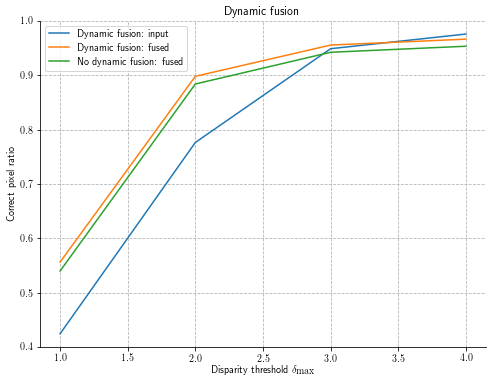

In [129]:
# dn_w = pd.read_csv(CSV_FILE_DN_W)
# dn_old = pd.read_csv(CSV_FILE_DN_OLDSCHOOLD)
# augment(dn_w)
# augment(dn_old)

# agggregate_accuracy_comparison(dn_w, dn_old, "Dispnet: dynamic fusion w", "Dispnet: fixed w")

# dn_w_300 = pd.read_csv("../csv/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-with-fusion-weights-300-depth-result.csv")
# dn_w_600_xsqrt = pd.read_csv("../csv/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-with-fusion-weights-2500-x(sqrt(x))-depth-result.csv")
# augment(dn_w_300)
# augment(dn_w_600_xsqrt)

# agggregate_accuracy_comparison(dn_w_300, dn_w_600_xsqrt, "Dispnet: dynamic fusion w", "Dispnet: more aggressive")

tracking6_dynamic = pd.read_csv("../csv/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-NO-fusion-weights-depth-result.csv")
tracking6_no_dynamic = pd.read_csv("../csv/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-NO-dynamic-NO-direct-ref-NO-fusion-weights-depth-result.csv")
augment(tracking6_dynamic)
augment(tracking6_no_dynamic)
agggregate_accuracy_comparison(tracking6_dynamic, tracking6_no_dynamic, "Dynamic fusion", "No dynamic fusion", False)

fig_fname = "dyamic-vs-no-dynamic-tracking-06-full-dispnet-crappy"
plt.savefig('../fig/{}.eps'.format(fig_fname))
plt.savefig('../fig/{}.png'.format(fig_fname))


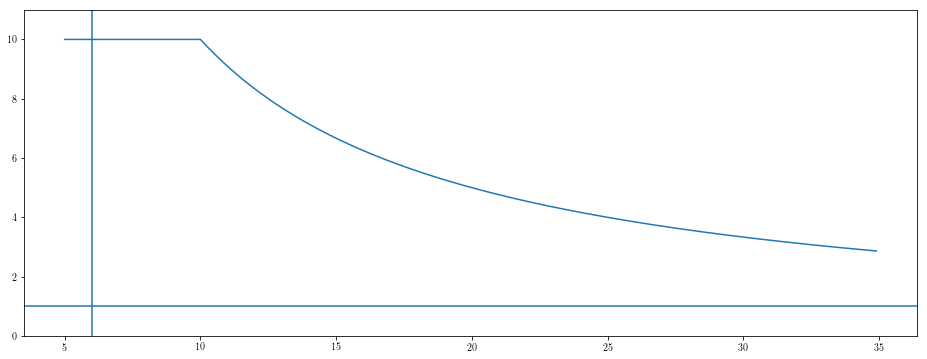

In [77]:
import math

x = np.arange(5, 35, 0.1)
y =  100 / (x) 
xmax = 10
y[y < 1] = 1
y[y > xmax] = xmax

plt.plot(x, y)
plt.ylim(0 , xmax * 1.1)
plt.axhline(1)
plt.axvline(6)